In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import warnings
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from alphalens.performance import mean_return_by_quantile
warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', False)

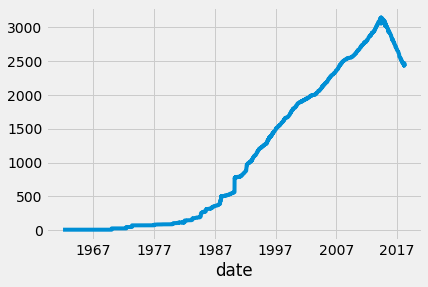

In [2]:
with pd.HDFStore('resample_test.h5') as store:
    df = store.get('data_clean')
df.count(1).plot();

In [2]:
def get_sp500_prices(start=2010, end=2017):
    with pd.HDFStore('assets.h5') as store:
        sp500 = store.get('sp500_constituents').ticker.tolist()
        asset_prices = store.get('wiki').adj_close.unstack().filter(sp500)
        return asset_prices.loc[str(start):str(end)].dropna(how='all', axis=1)


def get_wiki_prices(start=2010, end=2017):
    with pd.HDFStore('assets.h5') as store:
        asset_prices = store.get('wiki').adj_close.unstack().loc[str(start):str(end)]
        return asset_prices.dropna(thresh=int(len(asset_prices) * .8), axis=1)

In [7]:
prices = get_wiki_prices(2002, 2017).dropna(how='all')
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4057 entries, 2002-01-02 to 2017-12-29
Columns: 2024 entries, A to ZQK
dtypes: float64(2024)
memory usage: 62.7 MB


In [8]:
returns = prices.pct_change().fillna(0)
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4057 entries, 2002-01-02 to 2017-12-29
Columns: 2024 entries, A to ZQK
dtypes: float64(2024)
memory usage: 62.7 MB


In [67]:
pca = PCA()
ar = prices.resample('M').ffill().pct_change().fillna(0)
pca.fit(ar)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

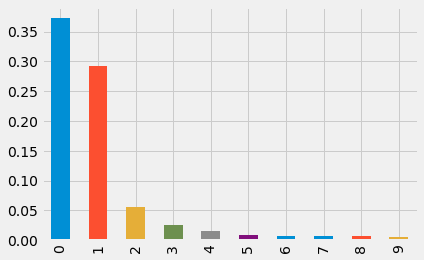

In [68]:
pd.Series(pca.explained_variance_ratio_).head(10).plot.bar();

In [69]:
pca.components_.shape

(192, 2024)

In [75]:
components = pca.components_
idx = np.argsort(components[:2, :], axis=1)
pc1 = ar.columns[idx[0, 5:50]]
pc2 = ar.columns[idx[1,  5:50]]
print(len(pc1.intersection(pc2)))

5


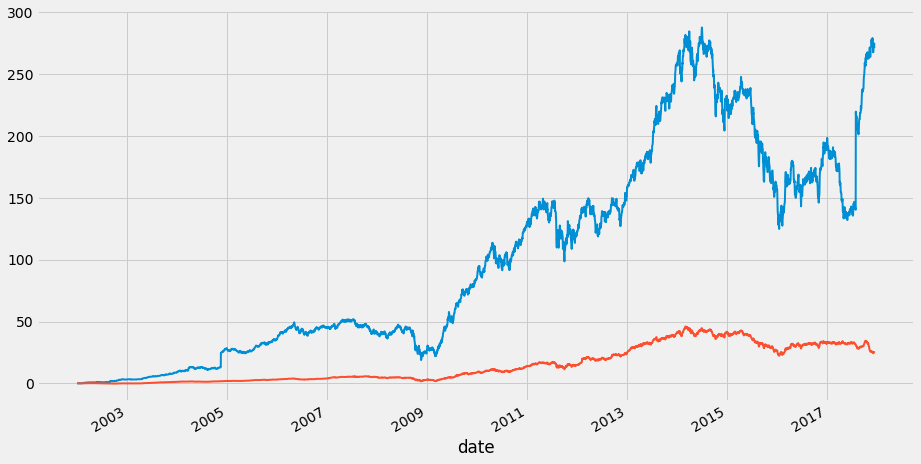

In [76]:
rets = {}
fig, ax = plt.subplots(figsize=(14,8))
for l, r in enumerate([pc1, pc2]):
    rets[l] = returns.loc[:, r].iloc[:-10]
    rets[l] = rets[l].sum(1).div(rets[l].count(1))
    rets[l].add(1).fillna(1).cumprod().sub(1).plot(ax=ax, lw=2)

In [1]:
def get_returns(x):
    return mean_return_by_quantile(x)[0]

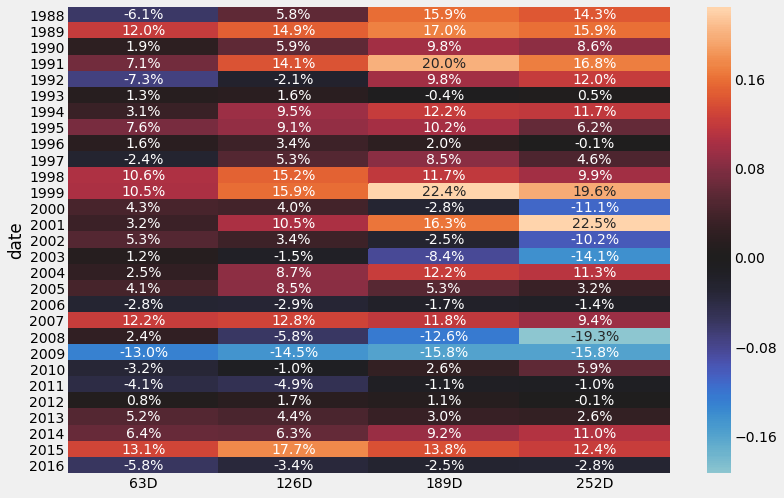

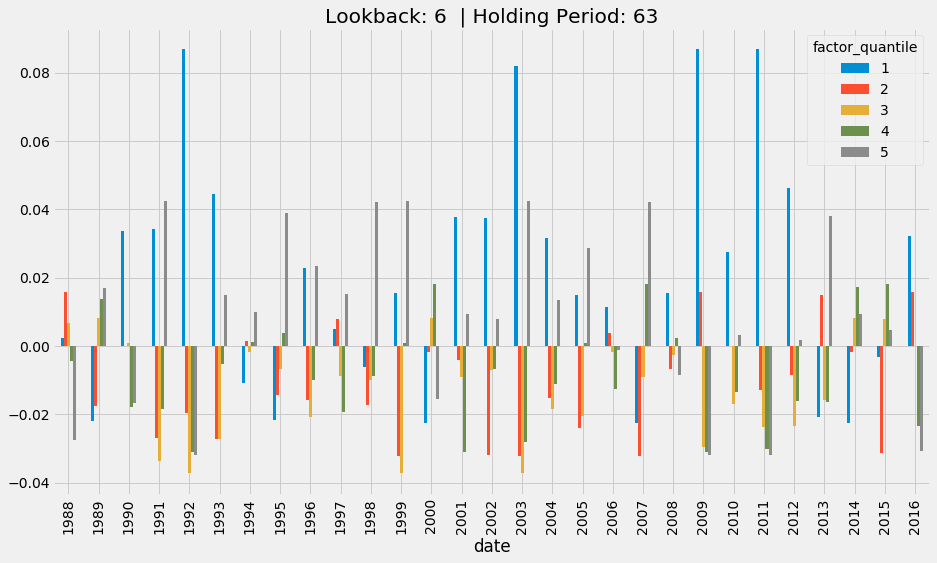

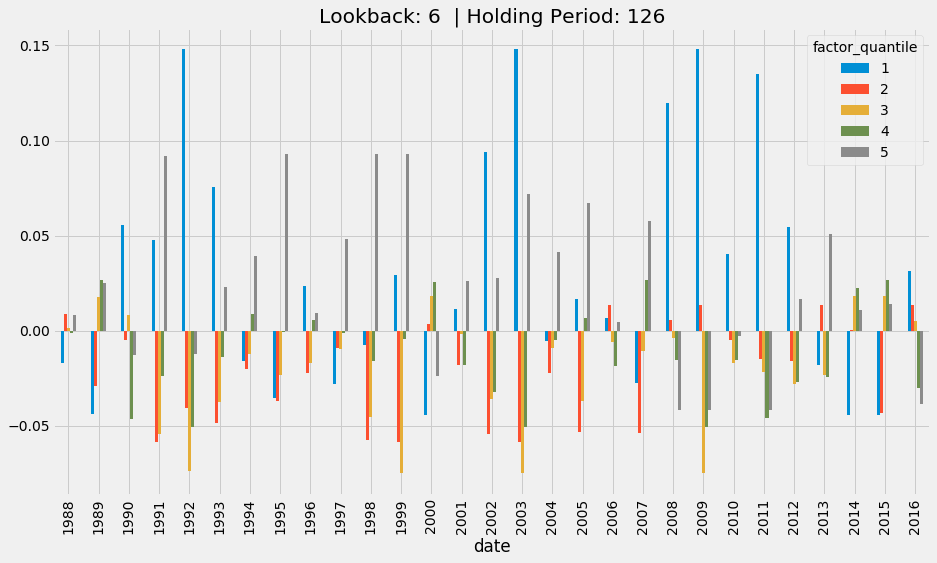

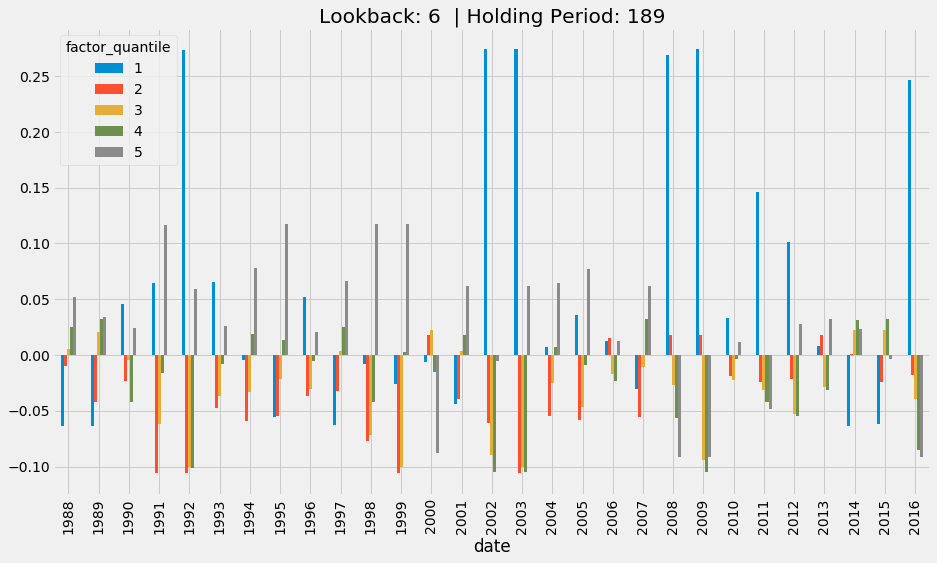

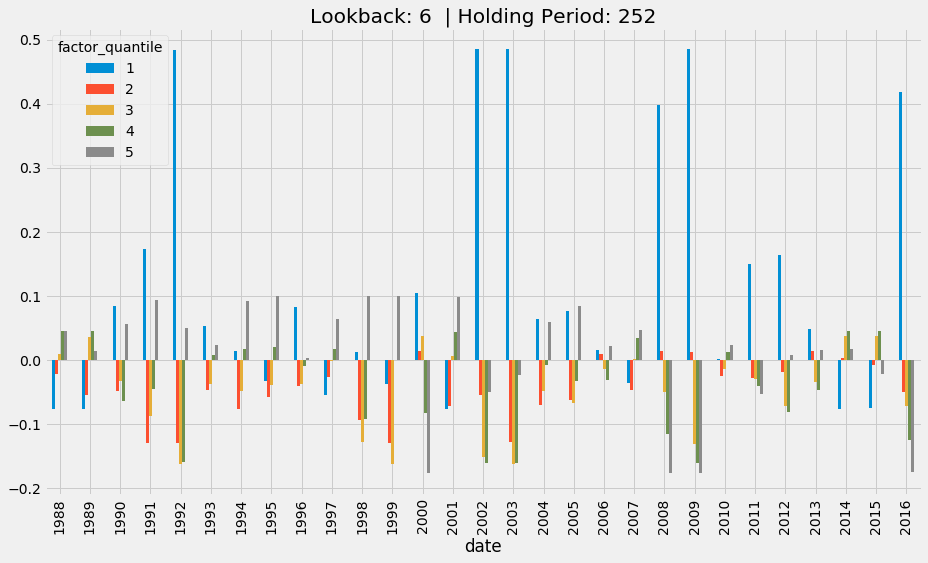

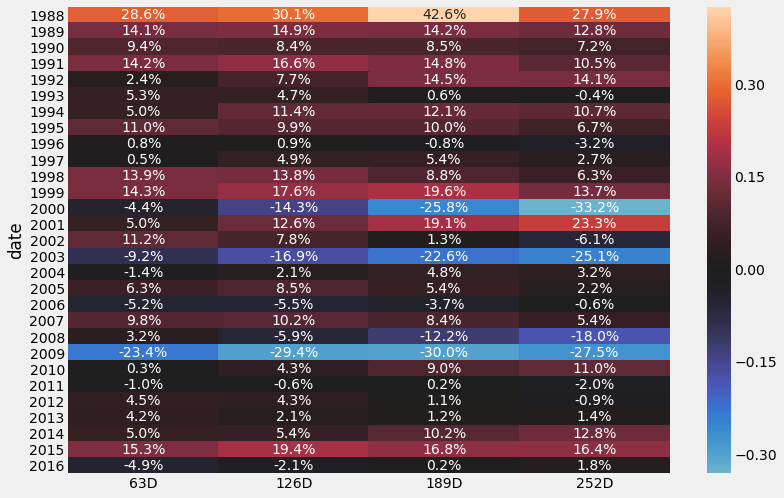

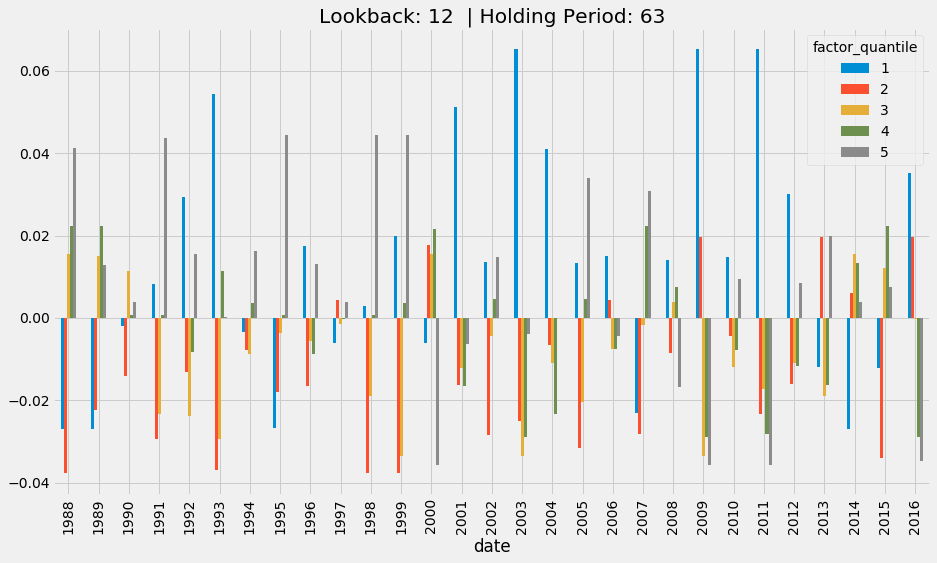

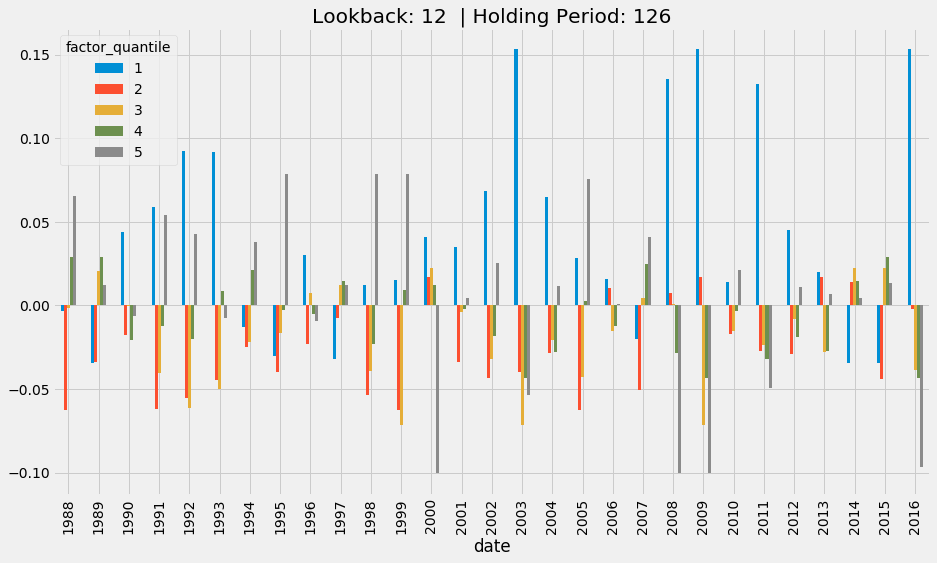

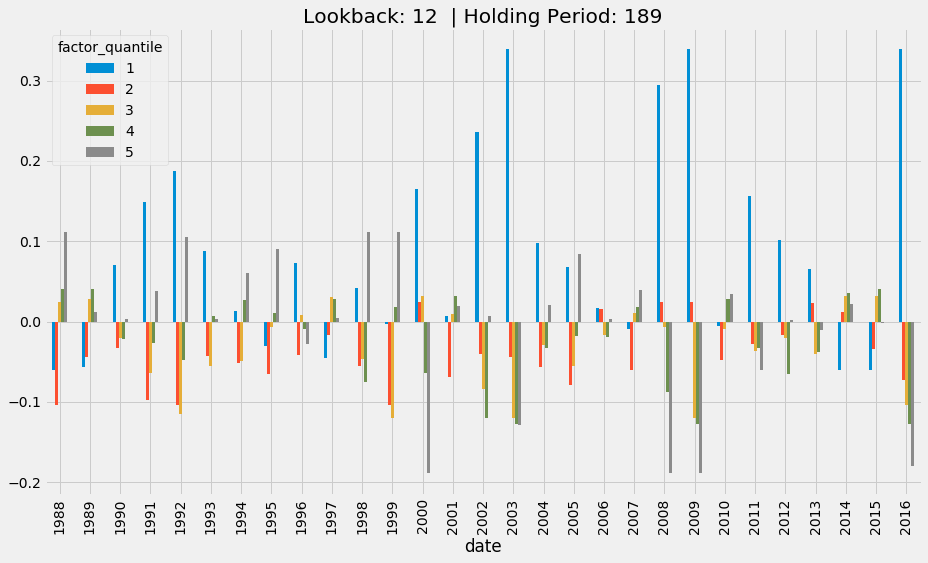

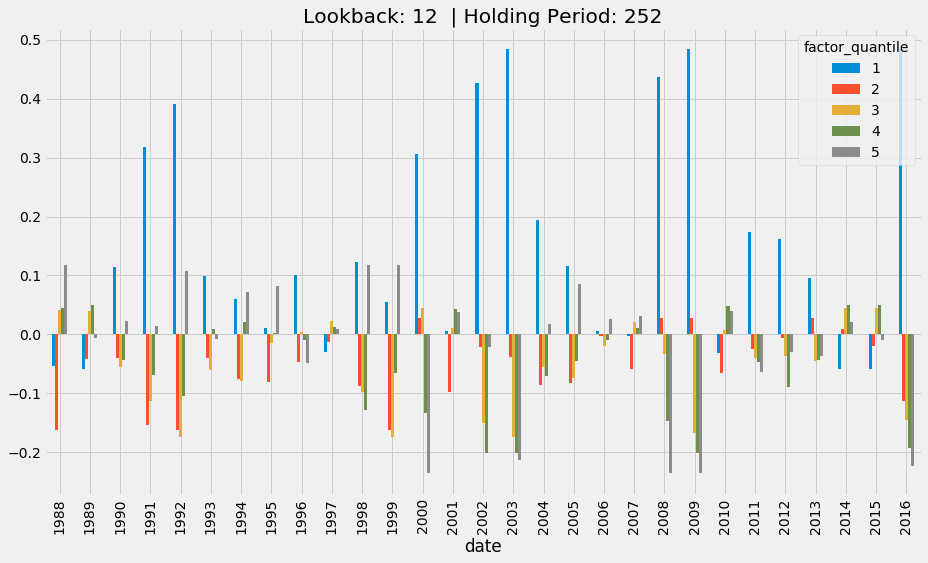

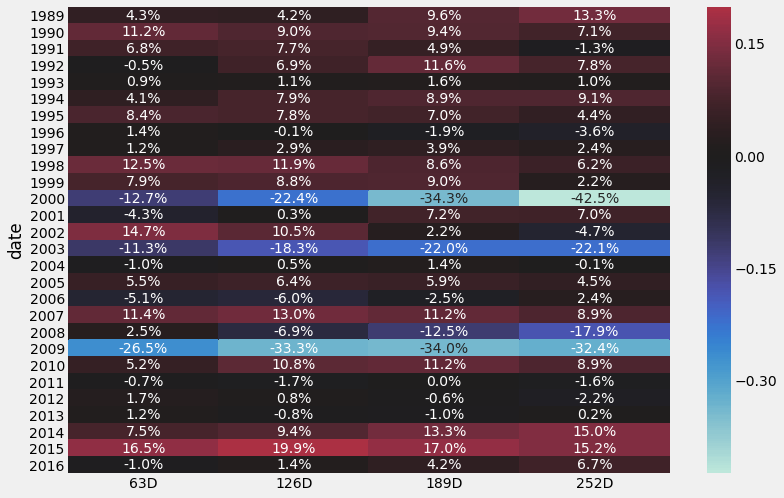

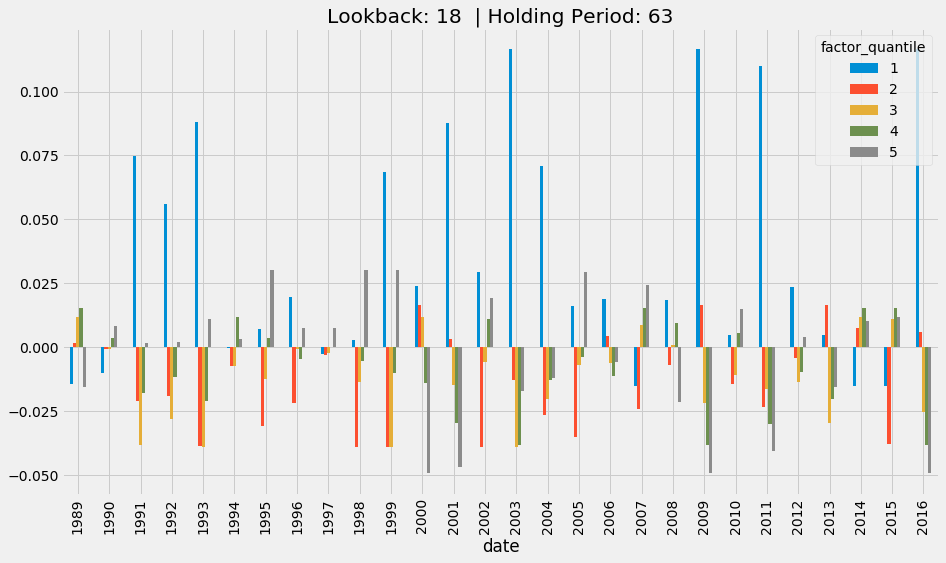

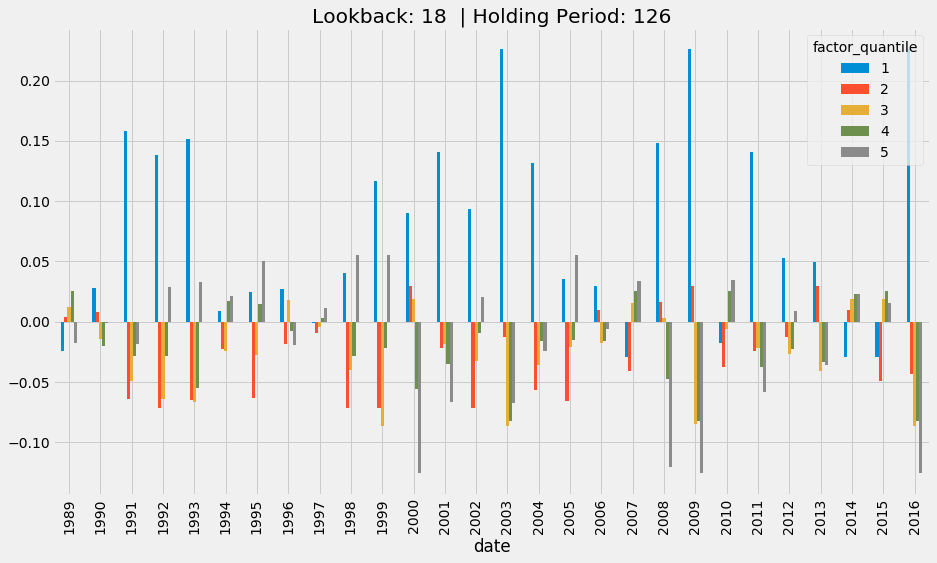

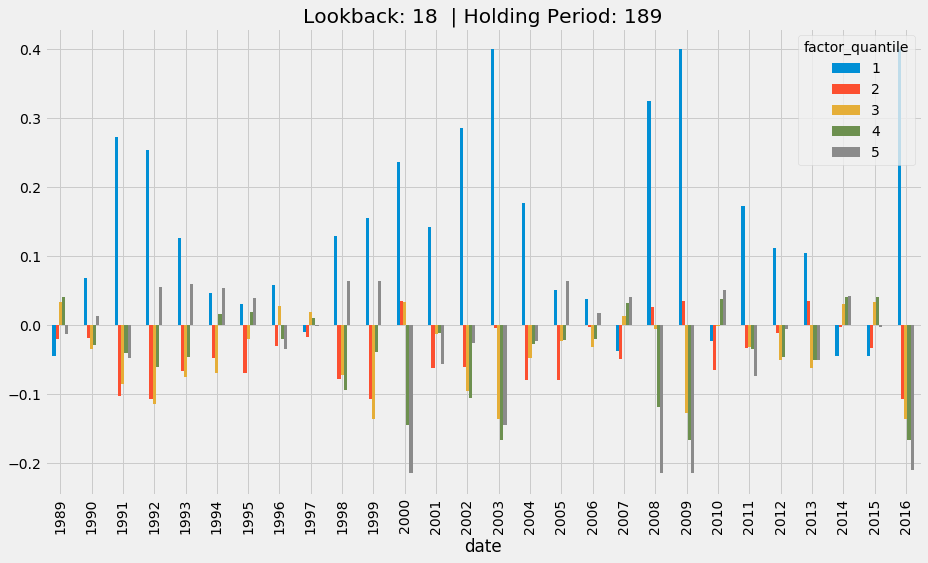

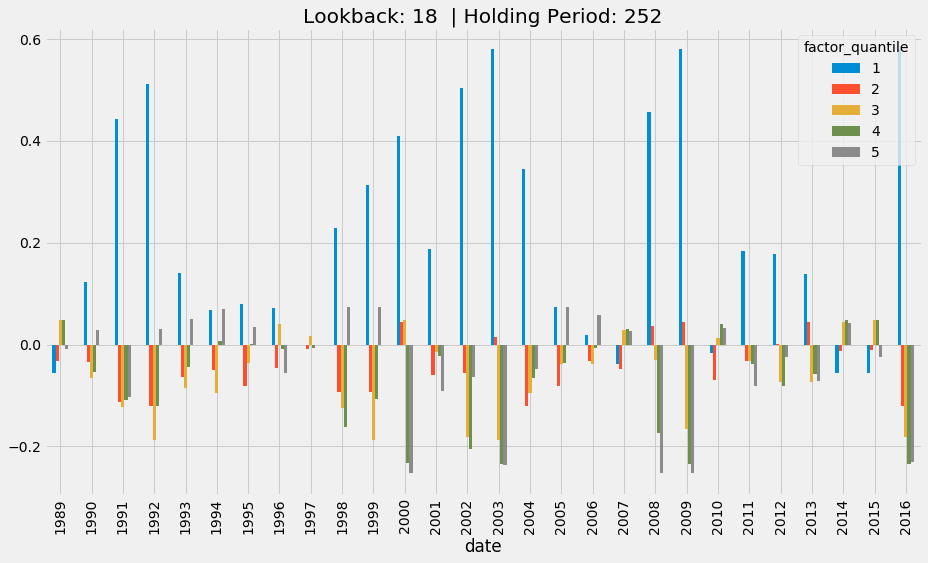

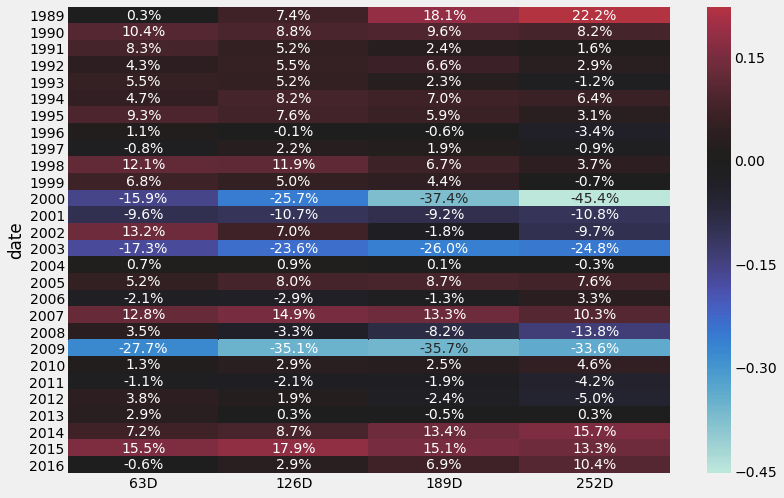

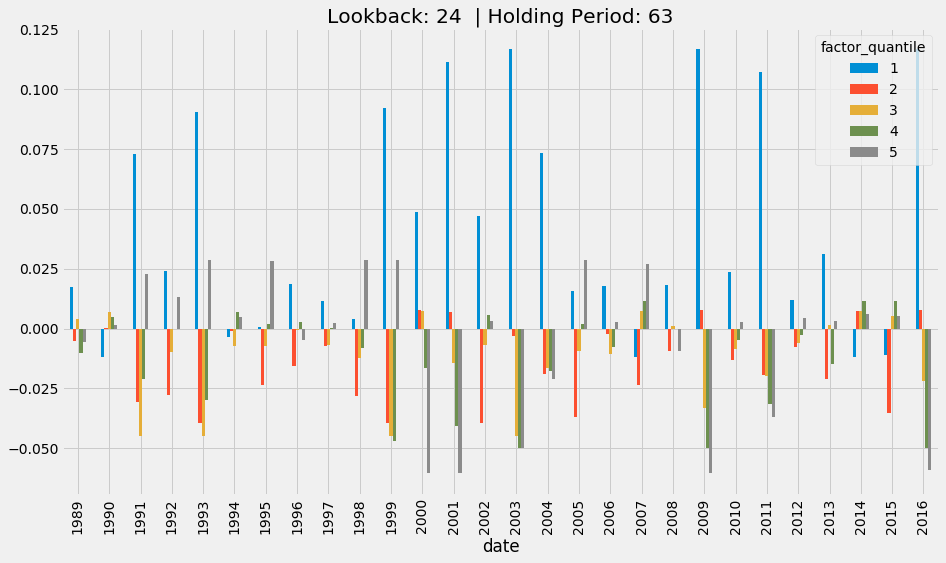

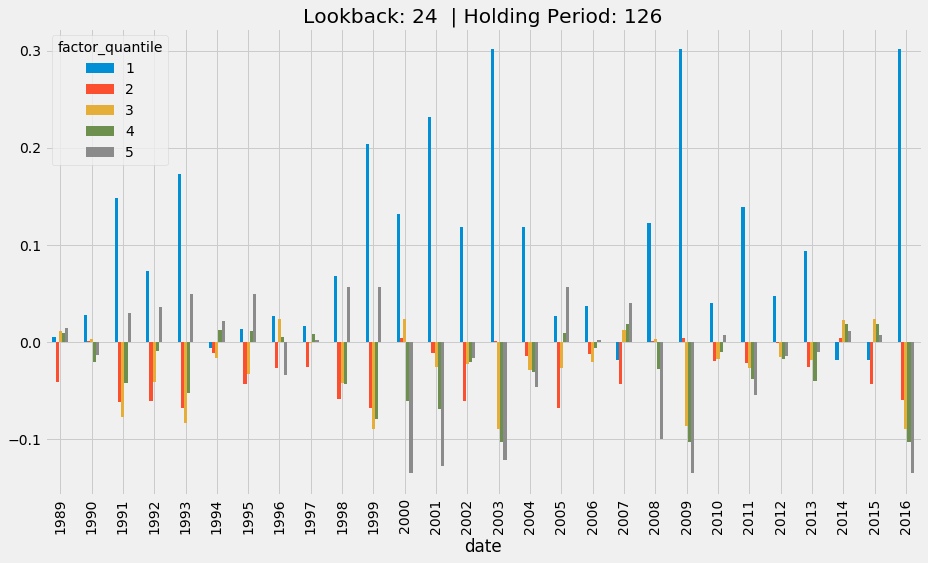

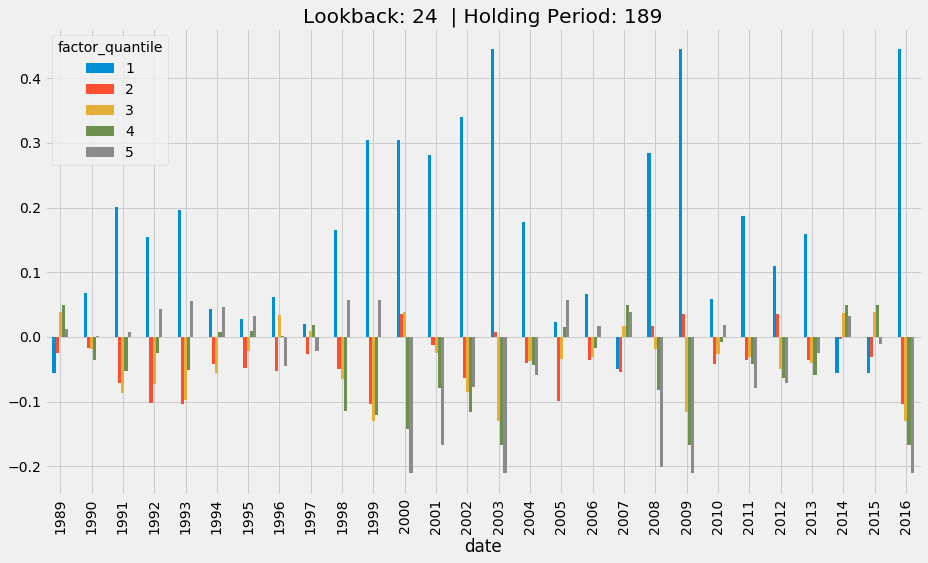

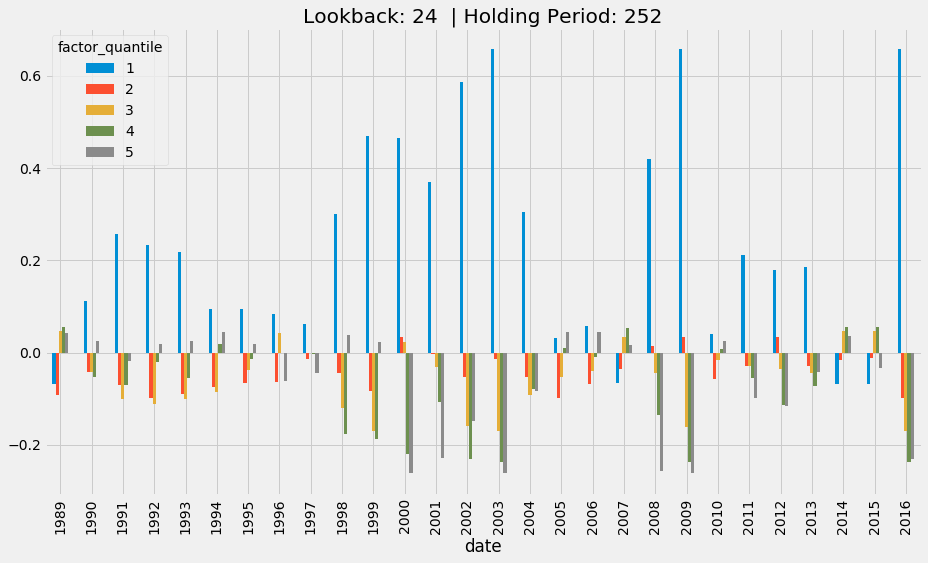

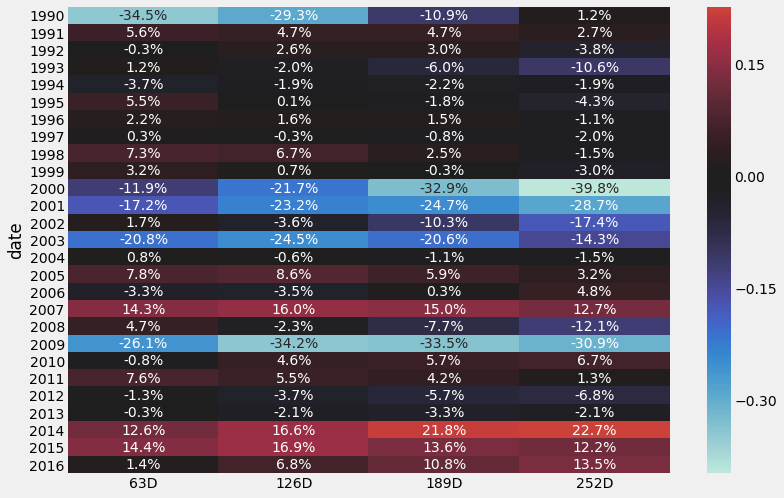

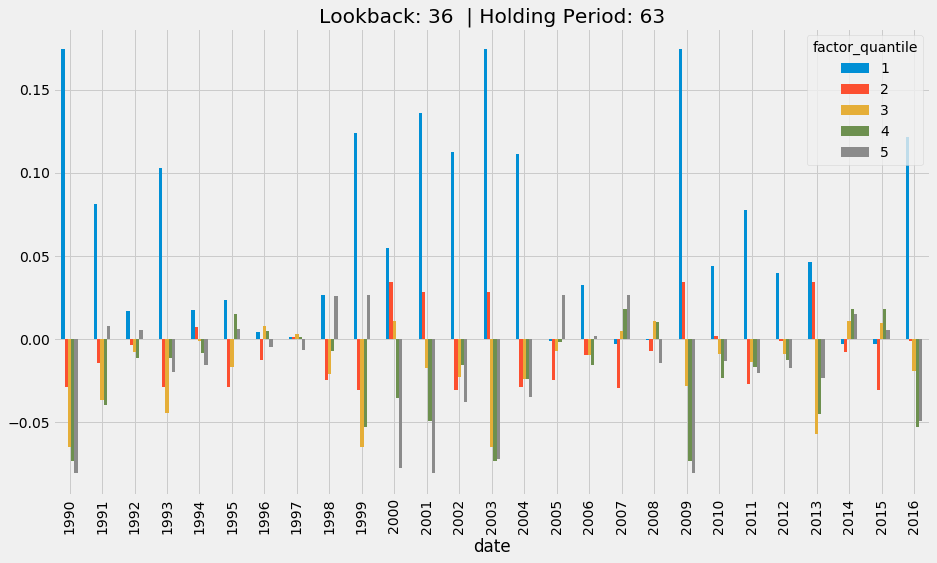

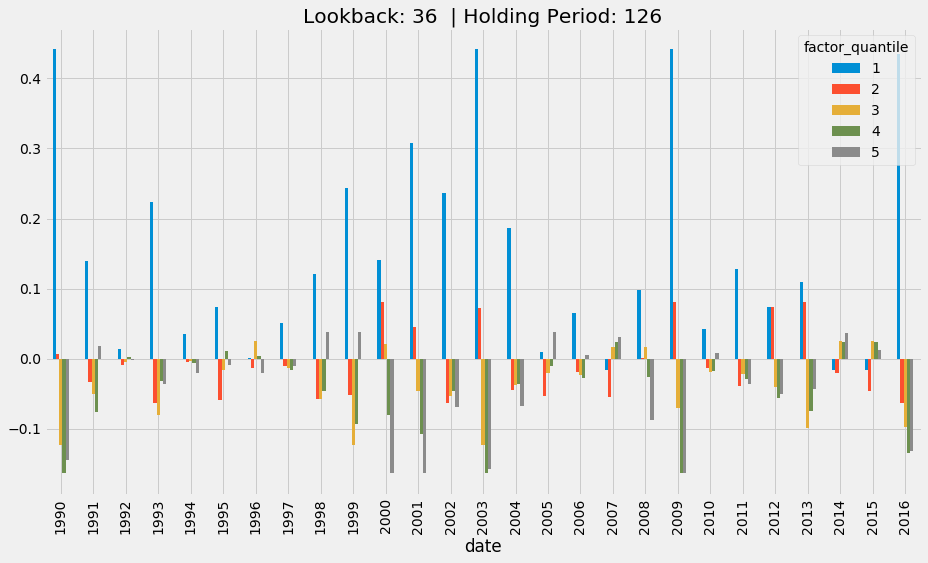

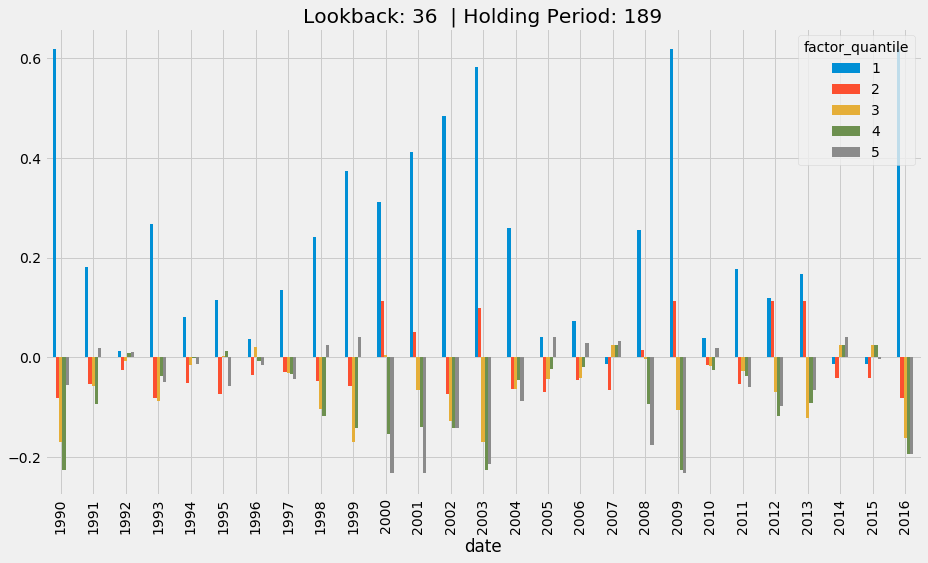

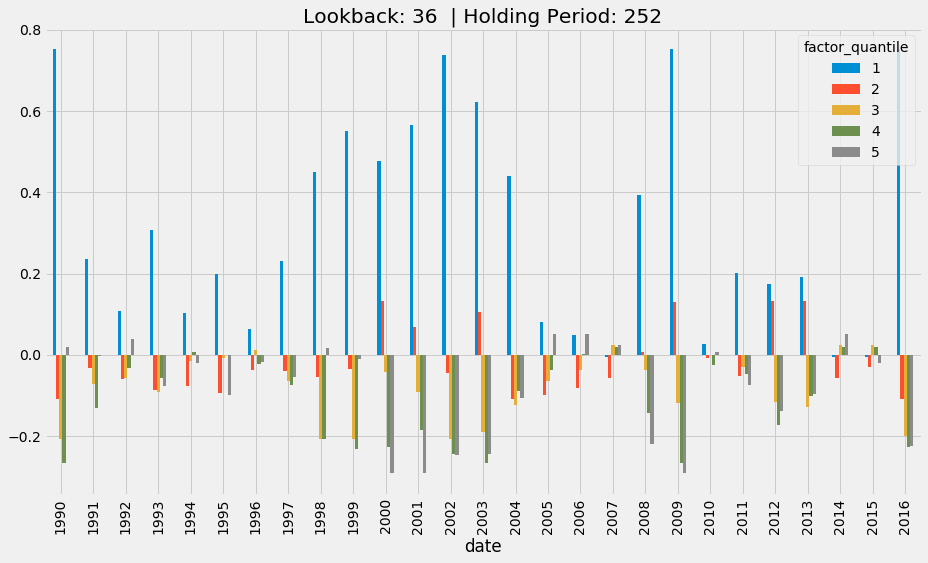

In [18]:
TRADING_DAYS = 21
holding_periods = [m * TRADING_DAYS for m in [3, 6, 9, 12]]
with pd.HDFStore('momentum_factor.h5') as store:
    for months in [6, 12, 18, 24, 36]:
        
        ic = store.get(f'momentum_overlay/ic/{months}/all').resample('A').mean()
        ic.index = ic.index.year
        fix, ax = plt.subplots(figsize=(12, 8))
        sns.heatmap(ic, center=0, annot=True, fmt='.1%')
        plt.show()

        factor_data = store.get(f'momentum_overlay/factor_data/{months}/all')
        returns = factor_data.groupby(pd.Grouper(level='date', freq='A')).apply(get_returns).unstack('factor_quantile')
        returns.index = returns.index.year
        for p in holding_periods:
            period = returns.loc[:, f'{p}D']
            period = period.apply(lambda x: x.clip(lower=x.quantile(.1), upper=x.quantile(.9)))
            period.plot.bar(figsize = (14, 8), title=f'Lookback: {months}  | Holding Period: {p}')
            plt.show()

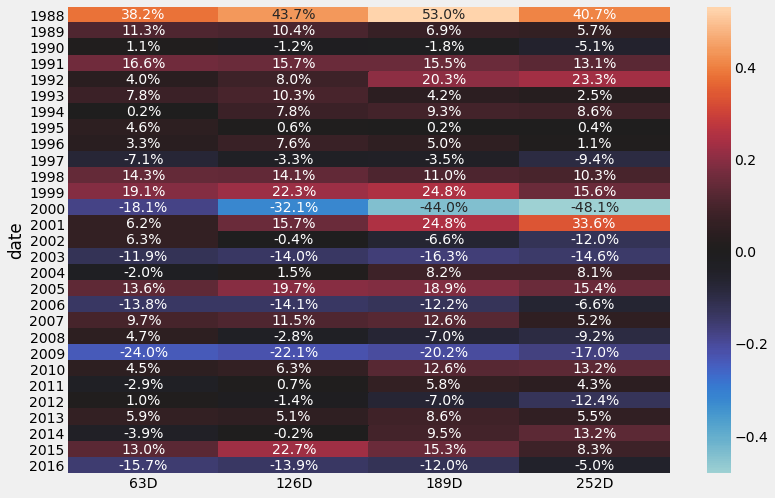

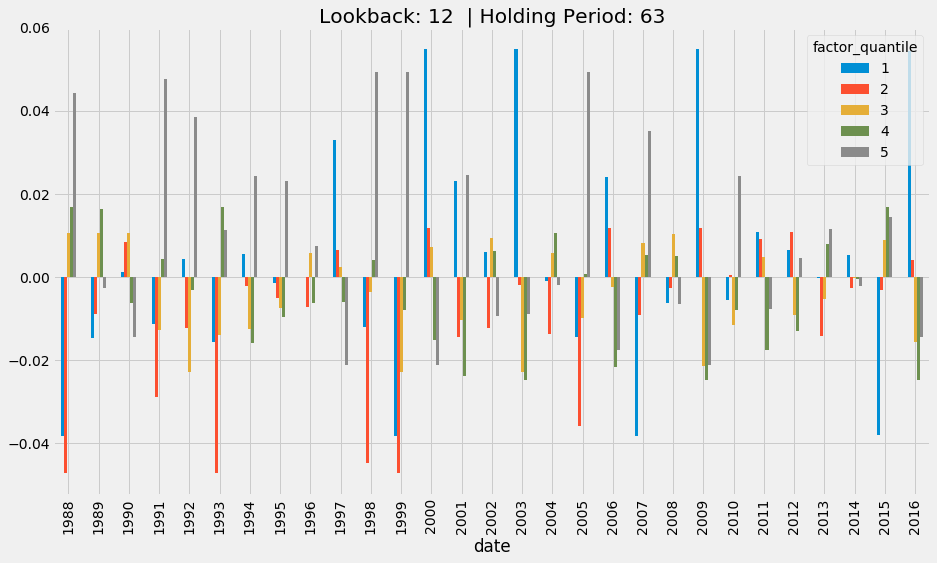

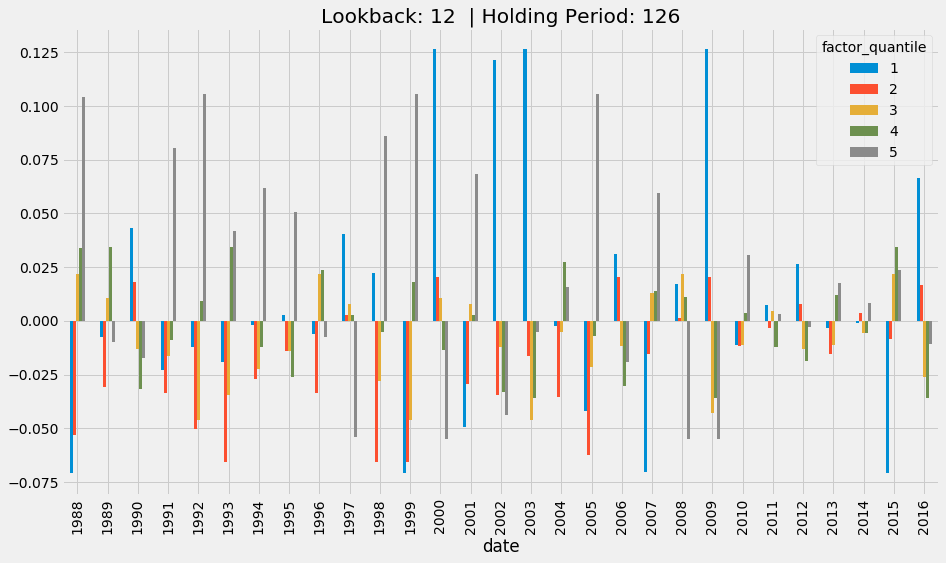

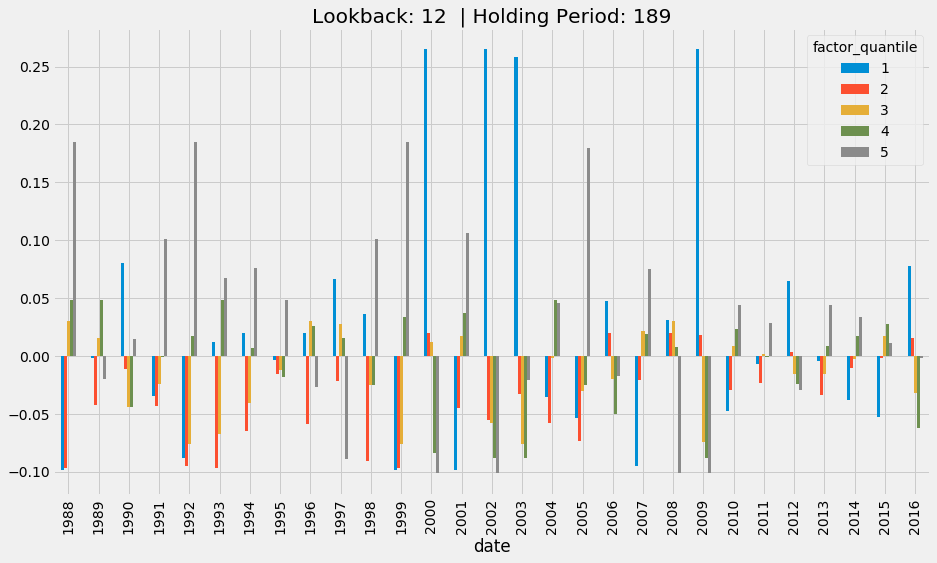

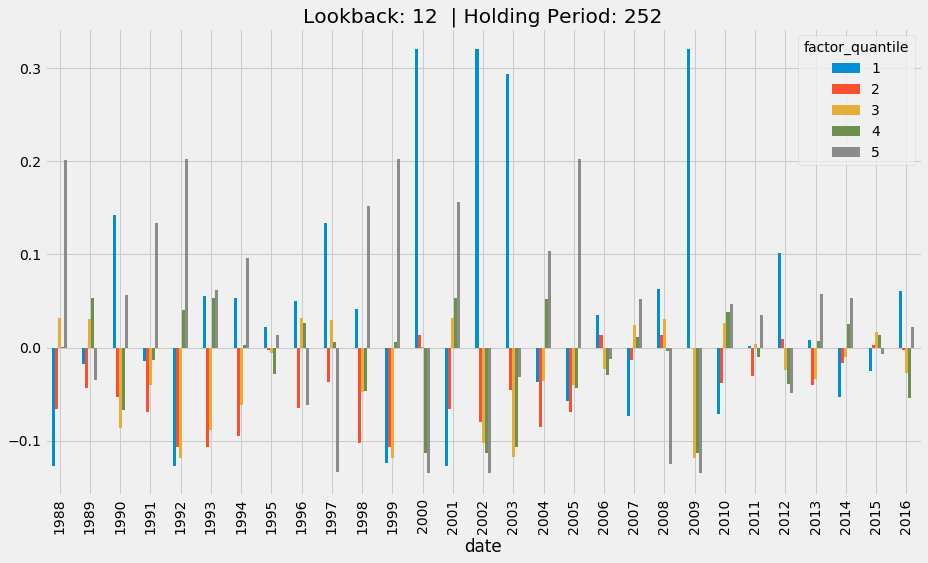

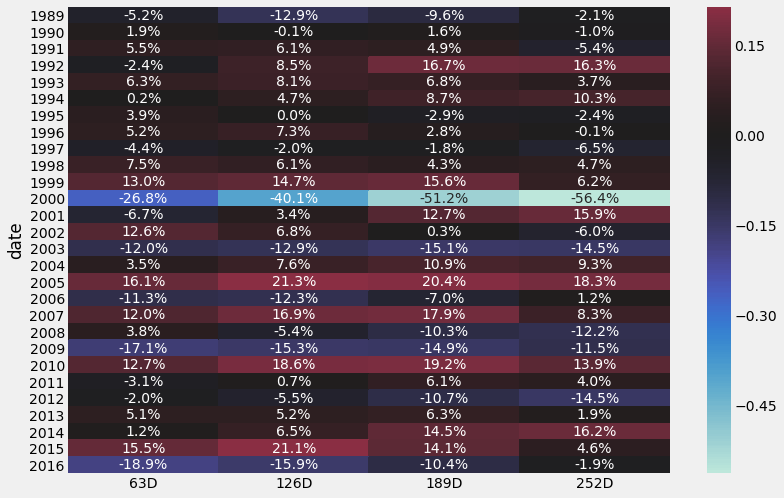

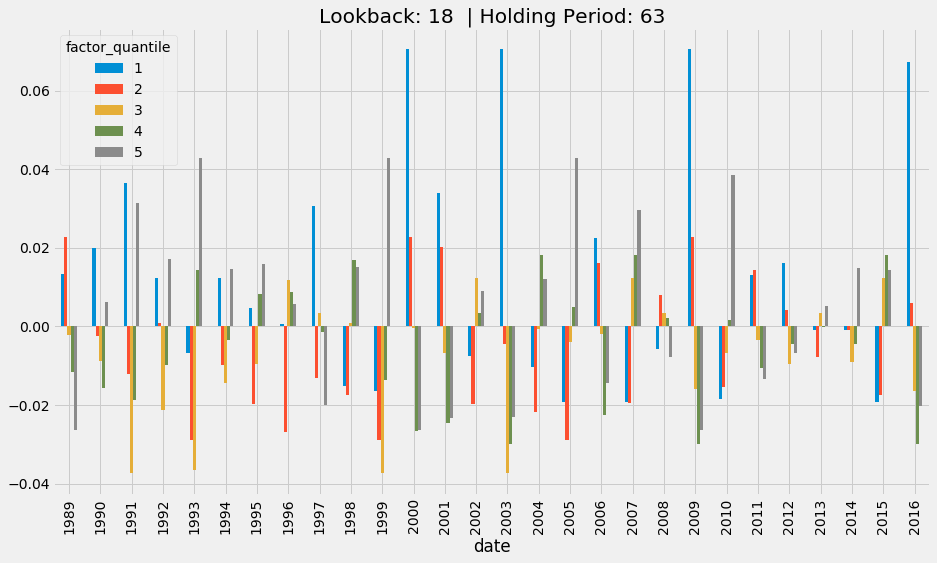

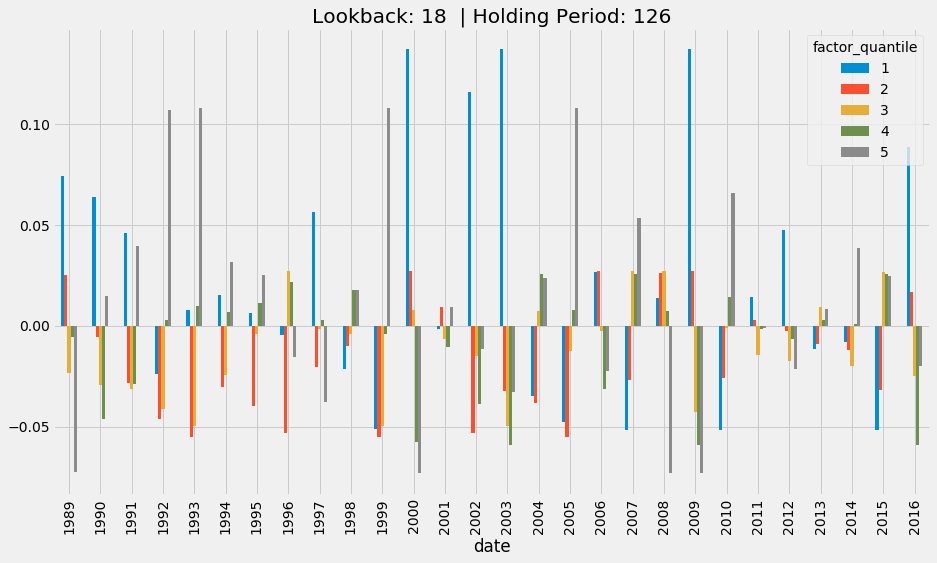

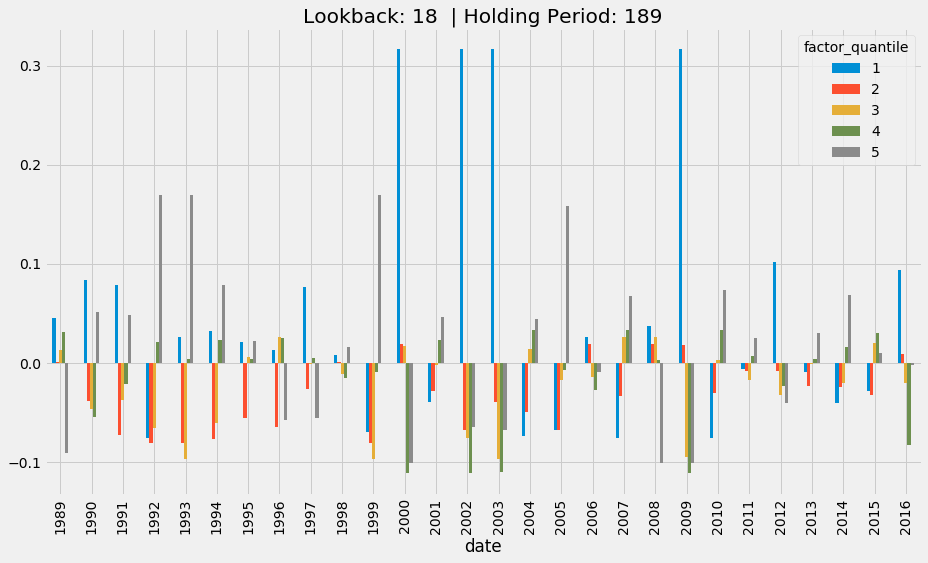

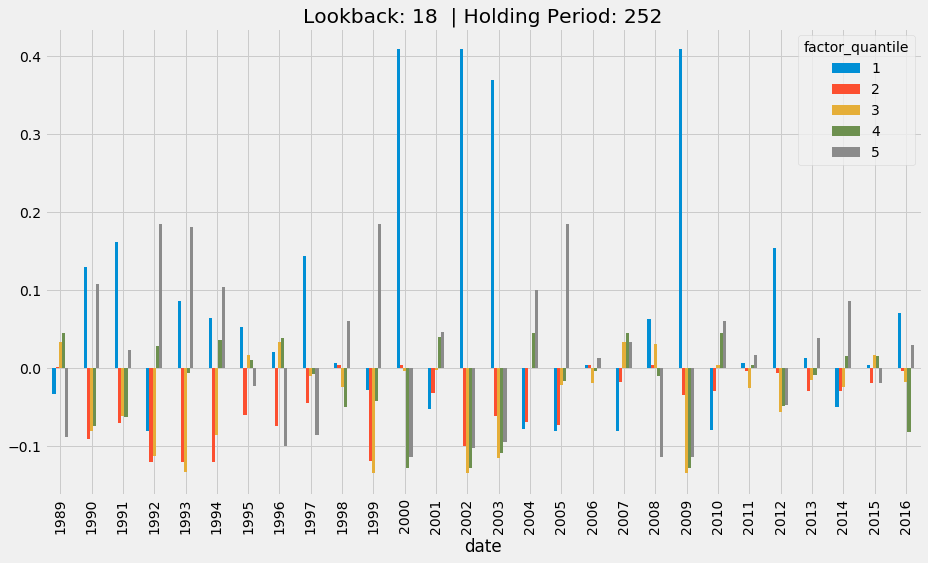

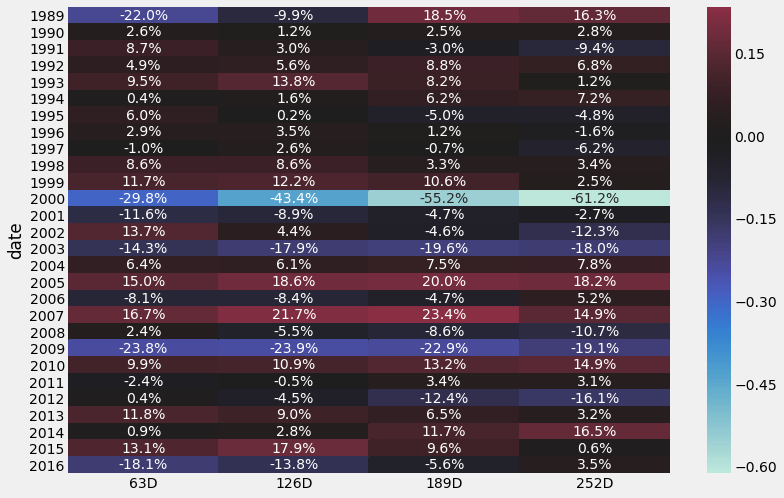

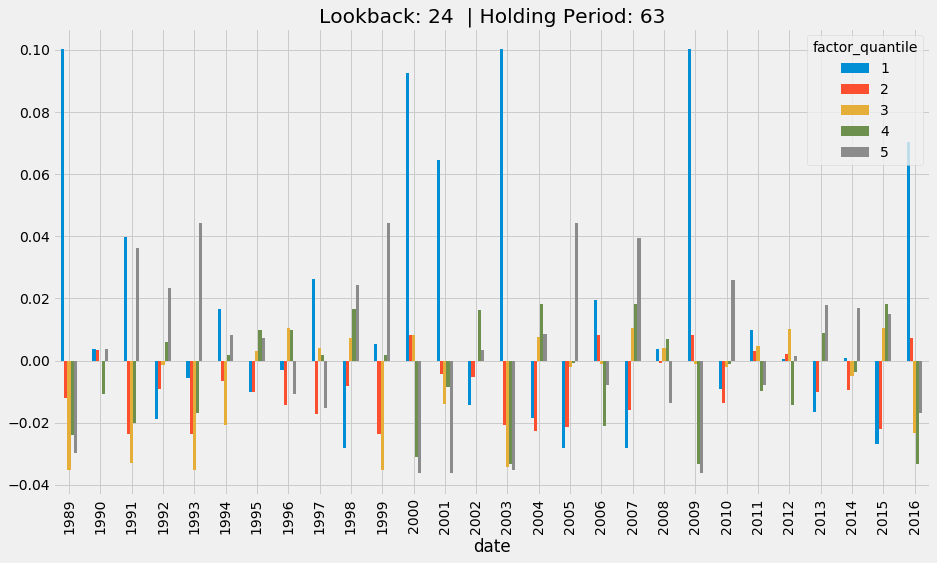

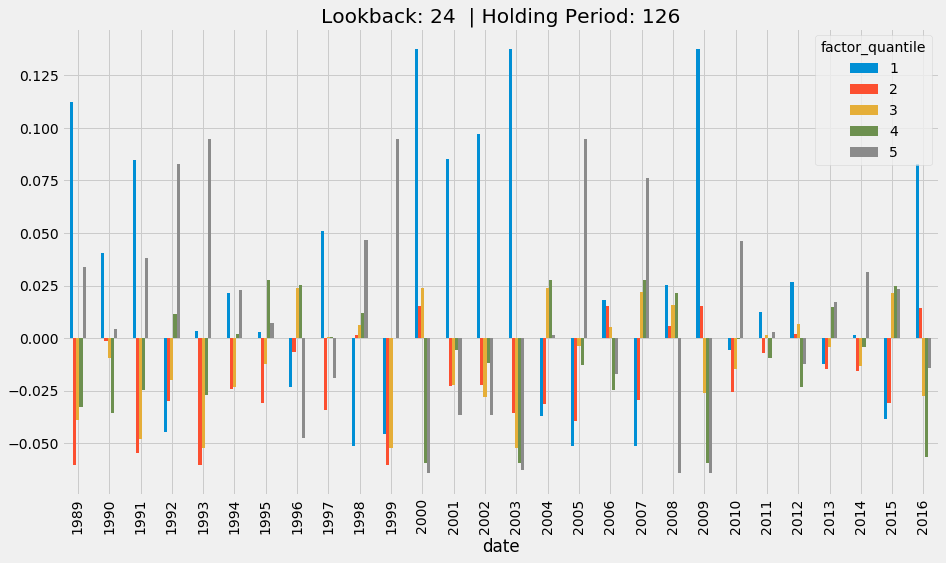

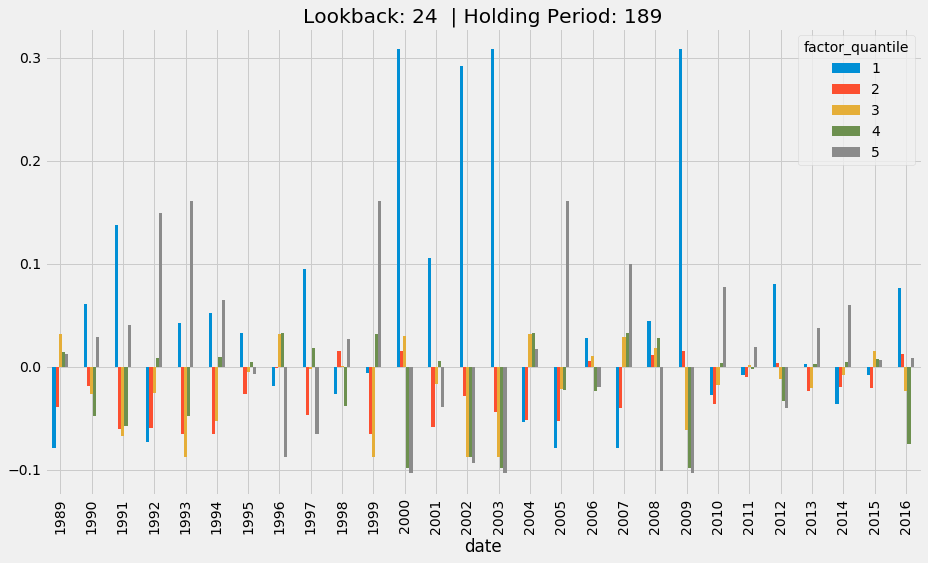

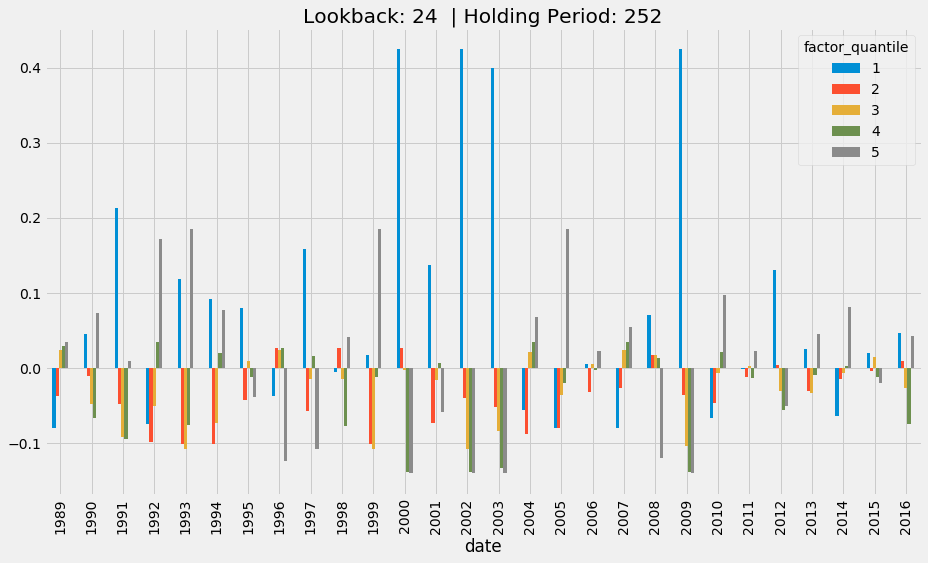

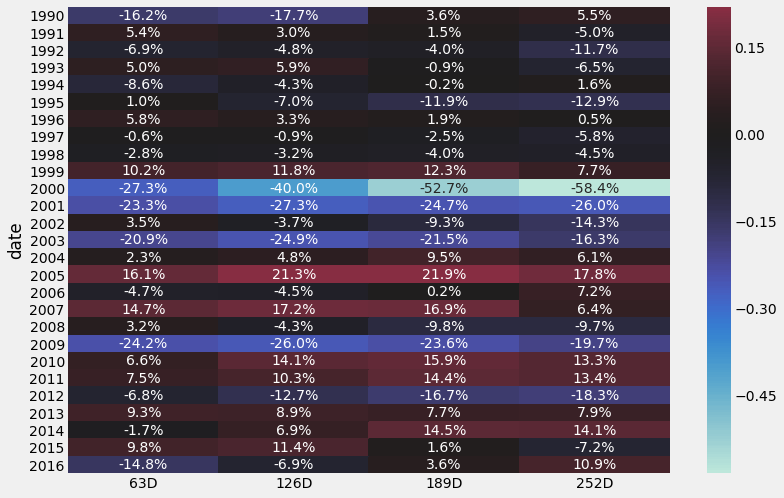

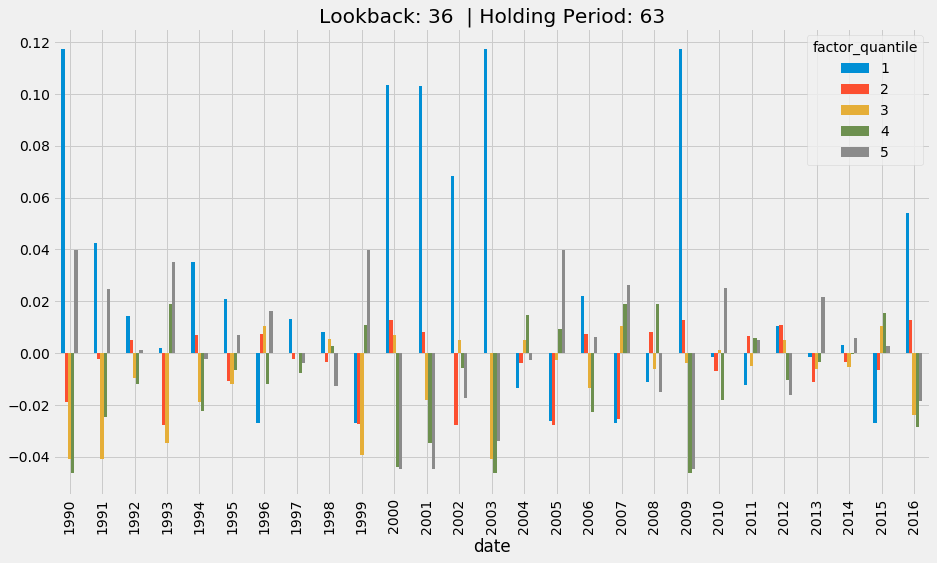

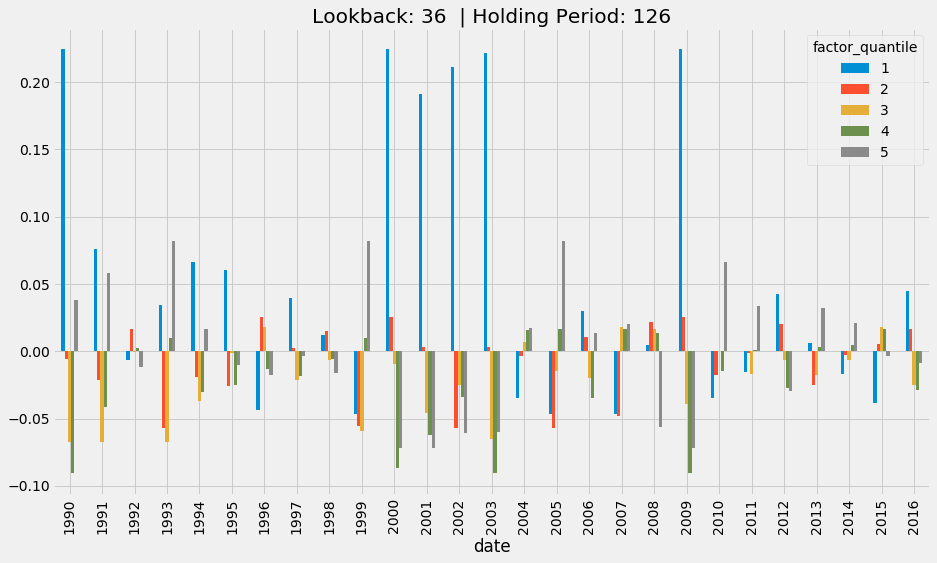

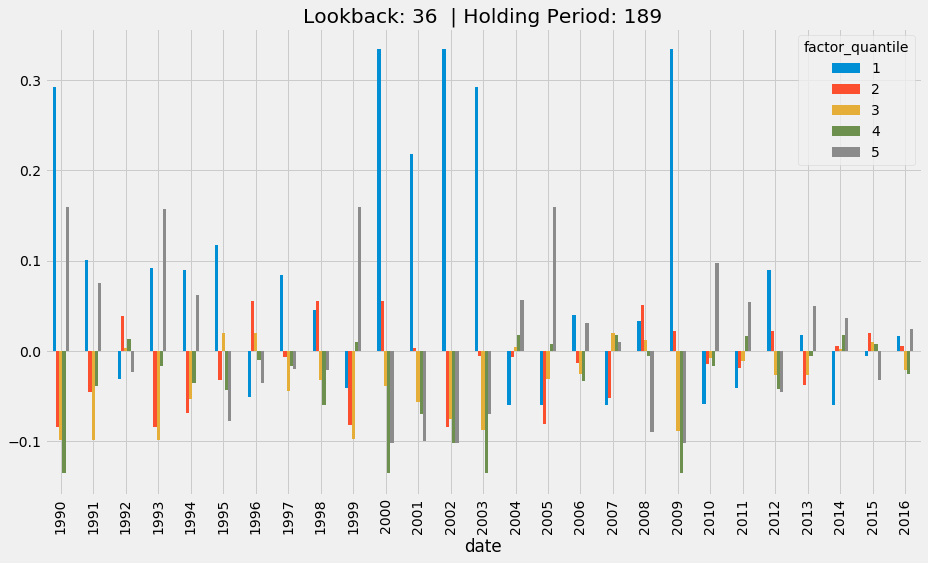

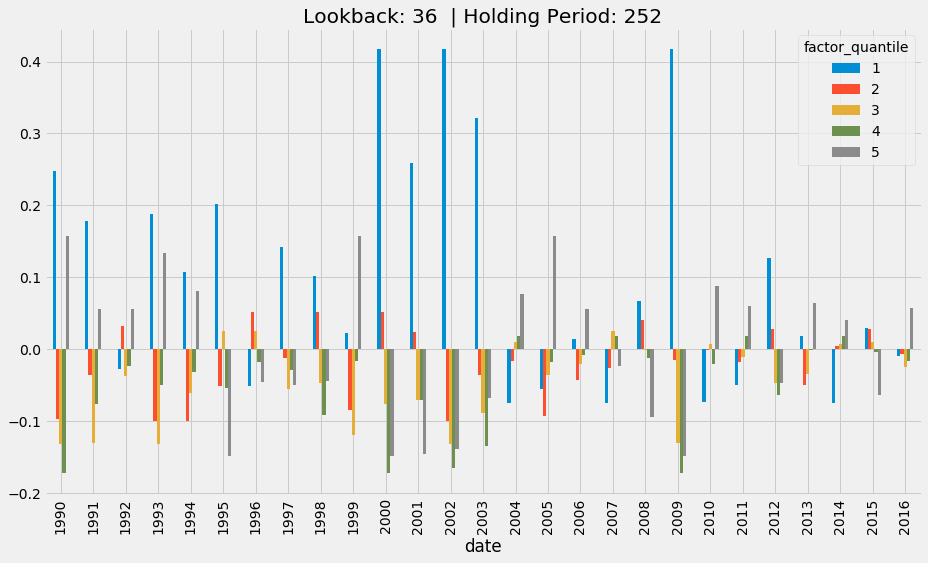

In [20]:
with pd.HDFStore('momentum_factor.h5') as store:
    for months in [12, 18, 24, 36]:
        ic = store.get(f'momentum_overlay/ic/{months}/sp500').resample('A').mean()
        ic.index = ic.index.year
        fix, ax = plt.subplots(figsize=(12, 8))
        sns.heatmap(ic, center=0, annot=True, fmt='.1%')
        plt.show()

        factor_data = store.get(f'momentum_overlay/factor_data/{months}/sp500')
        returns = factor_data.groupby(pd.Grouper(level='date', freq='A')).apply(get_returns).unstack('factor_quantile')
        returns.index = returns.index.year
        for p in holding_periods:
            period = returns.loc[:, f'{p}D']
            period = period.apply(lambda x: x.clip(lower=x.quantile(.1), upper=x.quantile(.9)))
            period.plot.bar(figsize = (14, 8), title=f'Lookback: {months}  | Holding Period: {p}')
            plt.show()